# Laboratory 5

### Cancer Growing and Chemical Treatment

Queremos minimizar a densidade do tumor e os efeitos colaterais das drogas. É assumido que o tumor tenha um crescimento Gompertzian. O modelo utilizado no laboratório é Skiper's log-kill hipótese, que afirma que a morte de células devido às drofas é proporcional a população de tumor. 

Considere $N(t)$ a densidade normalizada do tumor no tempo $t$. Assim:
$$N'(t) = rN(t)\ln(\frac{1}{N(t)}) - u(t)\delta N(t)$$
$r$ é a taxa de crescimento do tumor, $\delta$ a magnitude da dose e $u(t)$ descreve a ação da droga. É a força do efeito da droga. Escolhemos o funcional para ser 
$$\min_u \int_0^T aN(t)^2 + u(t)^2 dt$$

Além disso, $u(t) \geq 0$ e $N(0) = N_0$. 

### Condições Necessárias

Sabemos que a função $g$ é côncava em $N$ e $u$ e $f$ é convexa nessas variáveis, o que nos fornece informação sobre a existência da solução. Suponha a existência da solução $u^*(t)$. Assim:
$$ H(t,x,u,\lambda) := aN^2 + u^2 + \lambda[rN\ln(\frac{1}{N}) - u\delta N] $$

$$ -\frac{\partial H}{\partial N} =  - 2aN + \lambda[- r\ln(\frac{1}{N}) + r + u\delta] = \lambda '(t), \lambda(T) = 0 \\ 
\frac{\partial H}{\partial u} = 2u - \lambda\delta N $$

Assim, averiguamos os limites:
$\frac{\partial H}{\partial u} > 0 \implies u(t) = 0 \implies 0 > \lambda\delta N \\
\frac{\partial H}{\partial u} = 0 \implies 0 \leq u^*(t) = \frac{1}{2}\lambda\delta N$


Assim $u^*(t) = \max(0,\frac{1}{2}\lambda\delta N)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Cancer():
    
    def __init__(self,a,r,T,delta,x0):
        self.a = a
        self.r = r
        self.T = T
        self.delta = delta
        self.x0 = x0
        
    def u(self,t,x,adj):
        return max(0,1/2*adj*self.delta*x)
    
    def dx(self,t,x,adj):
        return self.r*x*np.log(1/x) - self.u(t,x,adj)*self.delta*x
    
    def dadj(self,t,x,adj):
        return -2*self.a*x + adj*(-self.r*np.log(1/x) + self.r + self.u(t,x,adj)*self.delta)
    
    def runge_kutta_state(self,t,x,adj,N,h):

        for k in range(N):
            k1 = self.dx(t[k],x[k],adj[k])
            k2 = self.dx(t[k]+h/2,x[k] + h*k1/2,adj[k])
            k3 = self.dx(t[k]+h/2,x[k]+h*k2/2,adj[k])
            k4 = self.dx(t[k] + h, x[k] + h*k3, adj[k])
            x[k+1] = x[k] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        return x

    def runge_kutta_adj(self,t,x,adj,N,h):
    
        for k in range(N,0,-1):
            k1 = self.dadj(t[k],x[k],adj[k])
            k2 = self.dadj(t[k] - h/2,x[k],adj[k] + h*k1/2)
            k3 = self.dadj(t[k] - h/2,x[k],adj[k]+h*k2/2)
            k4 = self.dadj(t[k] - h, x[k],adj[k] + h*k3)
            adj[k-1] = adj[k] - (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        return adj
    
    def solve(self):
        #parameters
        N = 100
        h = 1/N
        p = 0.1
        test = -1
        t = np.linspace(0,self.T,N + 1)
        
        #variables
        x = np.zeros(N + 1)
        adj = np.zeros(N + 1)
        u = np.zeros(N + 1)
        x[0] = self.x0
        adj[-1] = 0

        while test < 0:
        
            old_u = u.copy()
            old_x = x.copy()
            old_adj = adj.copy()
        
            x = self.runge_kutta_state(t,old_x,old_adj,N,h)

            adj = self.runge_kutta_adj(t,x,old_adj,N,h)
            
            for i in range(len(u)): 
                u[i] = 0.5*(self.u(0,x[i],adj[i]) + old_u[i])

            temp1 = p*sum(abs(u)) - sum(abs(old_u - u))
            temp2 = p*sum(abs(x)) - sum(abs(old_x - x))
            temp3 = p*sum(abs(adj)) - sum(abs(old_adj - adj))
            test = min(temp1,temp2,temp3)
        
        return t,x,u,adj

In [3]:
def plotting(t,x):
    """ x is a dictionary with the name and a list with lists of the informations to plot"""
    fig = plt.figure(figsize=(12,10))
    for i in range(len(x.keys())):
        plt.subplot(3,1,i+1)
        for j in x[list(x.keys())[i]]:
            plt.plot(t,j)
        plt.title(list(x.keys())[i])

### Patâmetros para Teste


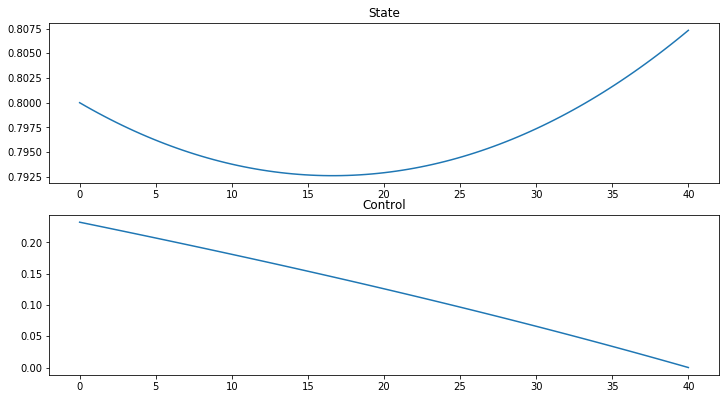

In [4]:
a,r,T,delta,x0 = 1,0.3,40,0.45,0.8

problem = Cancer(a,r,T,delta,x0)
t,x,u,_ = problem.solve()

plotting(t,{'State': [x], 'Control':[u]})